#### Detect model from Yu, et al
Implementation of the detection model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)

Refinement on first run. Still tries to follow the paper as closely as possible, but some changes from the first run:
- None type subsampled to keep only 30,000 random samples before resizing or filtering.
- Data was first resized to 60x60 in preparation for using Tensorflow image functions.  Ultimately, the data was resized to 224x224, median filtered 7x7, and normalized using Tensorflow image functions.
- Added last fully connected layer (FC3) that was accidentally omitted in the first run.
- Saved both model and predictions.

*Run on GCP Instance: a2-highgpu-1g, 12 cores + NVIDIA Tesla A100*

In [1]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install pickle5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 KB 7.9 MB/s eta 0:00:00


In [2]:
# access data from GCP bucket
!gsutil cp gs://wafdef/data/* ../../data/

Copying gs://wafdef/data/WM-clean2-dev.pkl...
Copying gs://wafdef/data/WM-clean2-test.pkl...                                  
Copying gs://wafdef/data/WM-clean2-train-clsaug.pkl...                          
Copying gs://wafdef/data/WM-clean2-train-detund.pkl...                          
/ [4 files][569.9 MiB/569.9 MiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://wafdef/data/WM-clean2-train-knn.pkl...
Copying gs://wafdef/data/WM-clean2-train.pkl...                                 
Copying gs://wafdef/data/knn_sanitize_indices.pkl...                            
Omitting prefix "gs://wafdef/data/resized224/". (Did you mean to do cp -r?)     

Operation completed over 7 objects/784.4 MiB.                                    


In [5]:
# import libraries
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, optimizers

import os
import numpy as np
import pandas as pd
import pickle5 as pickle

import helpers as helper
import seaborn as sns
from sklearn.metrics import confusion_matrix
from skimage.transform import resize as sk_resize

import time

In [6]:
# specify variables for model
path = '../../data'
filename = 'WM-clean2'
option = '-detund' # -clsaug, -detund
map_column = 'waferMap'
label_column = 'detectLabels'
filetype = 'pkl' # zip, pkl

model_id = 'yudetect'
result_path = '../../results'
note = '-refined' # -optional

In [7]:
# load train, dev, and test sets
start = time.time()

if filetype == 'pkl':
    # open pkl files
    with open(f'{path}/{filename}-train{option}.pkl', "rb") as fh:
        train = pickle.load(fh)
    with open(f'{path}/{filename}-dev.pkl', "rb") as fh:
        dev = pickle.load(fh)
    with open(f'{path}/{filename}-test.pkl', "rb") as fh:
        test = pickle.load(fh)

elif filetype == 'zip':
    train = helper.load(f'{path}/{filename}-train{option}.zip')
    dev = helper.load(f'{path}/{filename}-dev.zip')
    test = helper.load(f'{path}/{filename}-test.zip')

print("Wall time: {} seconds".format(time.time() - start))
print()
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Wall time: 0.47554445266723633 seconds

Train: 47863
Dev: 25942
Test: 25943


#### Quick EDA

In [8]:
# baseline accuracy of test set
nones = len(test[test.failureType == 'none'])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Baseline accuracy: 85.24%


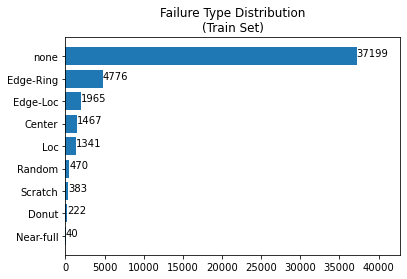

In [9]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

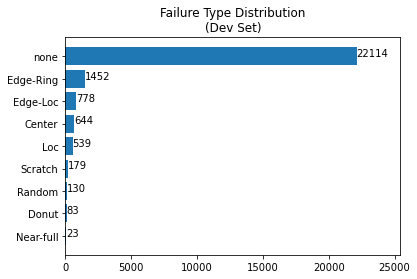

In [10]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

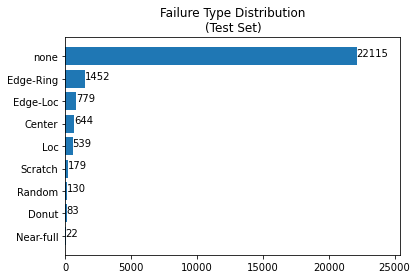

In [11]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [12]:
# resize images to 60x60 to use tensorflow utilities
start = time.time()

train['resized_map'] = train.waferMap.apply(lambda x: sk_resize(x, [60, 60], anti_aliasing=True))
dev['resized_map'] = dev.waferMap.apply(lambda x: sk_resize(x, [60, 60], anti_aliasing=True))
test['resized_map'] = test.waferMap.apply(lambda x: sk_resize(x, [60, 60], anti_aliasing=True))

print("Wall time: {} seconds".format(time.time() - start))

Wall time: 37.524884939193726 seconds


In [13]:
# prepare inputs
start = time.time()

x_train = np.stack(train['resized_map'])
x_val = np.stack(dev['resized_map'])
x_test = np.stack(test['resized_map'])

print("Wall time: {} seconds".format(time.time() - start))

# sanity check
# expected: (#rows, xdim, ydim)
x_train.shape

Wall time: 0.9781992435455322 seconds


(47863, 60, 60)

In [14]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
start = time.time()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

print("Wall time: {} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

2022-02-28 02:04:22.135404: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-28 02:04:23.718804: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38448 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


Wall time: 4.591567277908325 seconds


TensorShape([47863, 60, 60, 1])

In [15]:
# resize image to 224x224
start = time.time()

x_train = tf.image.resize(x_train, [224,224], antialias=True)
x_val = tf.image.resize(x_val, [224,224], antialias=True)
x_test = tf.image.resize(x_test, [224,224], antialias=True)

print("Wall time: {} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train[0].shape

2022-02-28 02:04:56.589213: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 9606295552 exceeds 10% of free system memory.


Wall time: 43.63777446746826 seconds


TensorShape([224, 224, 1])

In [16]:
x_train.shape

TensorShape([47863, 224, 224, 1])

In [17]:
# apply 7x7 median filter
start = time.time()

x_train = tfa.image.median_filter2d(x_train, (7, 7))
x_val = tfa.image.median_filter2d(x_val, (7, 7))
x_test = tfa.image.median_filter2d(x_test, (7, 7))

print("Wall time: {} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

2022-02-28 02:07:29.244694: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 438.38GiB (rounded to 470708482048)requested by op median_filter2d/ExtractImagePatches
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-02-28 02:07:29.244794: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-02-28 02:07:29.244809: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 1, Chunks in use: 1. 256B allocated for chunks. 256B in use in bin. 4B client-requested in use in bin.
2022-02-28 02:07:29.244816: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-02-28 02:07:29.244824:

ResourceExhaustedError: Graph execution error:

Detected at node 'median_filter2d/ExtractImagePatches' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 450, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 652, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 353, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2915, in run_cell
      raw_cell, store_history, silent, shell_futures)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3186, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_3221/4144320401.py", line 4, in <module>
      x_train = tfa.image.median_filter2d(x_train, (7, 7))
    File "/opt/conda/lib/python3.7/site-packages/tensorflow_addons/image/filters.py", line 177, in median_filter2d
      patches = tf.image.extract_patches(
Node: 'median_filter2d/ExtractImagePatches'
OOM when allocating tensor with shape[47863,224,224,49] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node median_filter2d/ExtractImagePatches}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_median_filter2d_96]

In [ ]:
# normalize images
start = time.time()

x_train = tf.image.per_image_standardization(x_train)
x_val = tf.image.per_image_standardization(x_val)
x_test = tf.image.per_image_standardization(x_test)

print("Wall time: {} seconds".format(time.time() - start))
# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

In [ ]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
y_train = np.asarray(train[label_column]).astype('int64')
y_val = np.asarray(dev[label_column]).astype('int64')
y_test = np.asarray(test[label_column]).astype('int64')

# sanity check
# expected: type = int, min = 0, max = 1
print(type(y_train[0]))
print(min(y_train), min(y_val), min(y_test))
print(max(y_train), max(y_val), max(y_test))

#### Model

In [ ]:
# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='sigmoid'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(2, activation='sigmoid'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

In [ ]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
# run model
history = model.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

In [ ]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [ ]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {} seconds".format(time.time() - start))
print()
print(results)

In [ ]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print("Wall time: {} seconds".format(time.time() - start))

In [ ]:
# save model predictions
with open(f'{result_path}/{model_id}-{filename}{option}{note}.pkl', "wb") as f:
    pickle.dump(y_pred, f)

In [ ]:
# save model
model.save(f'{result_path}/{model_id}-{filename}{option}{note}')

In [ ]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_pred, mode='detect', normalize=True)

In [ ]:
# plot confusion matrix counts
helper.plot_confusion_matrix(y_test, y_pred, mode='detect', normalize=False)